In [1]:
from pprint import pprint
import pickle
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tqdm import notebook
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pandas as pd
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#%matplotlib inline


In [2]:

def load_json_from_file(filename):
    with open(filename, "r") as f:
        return json.load(f, strict=False)


def dump_json_to_file(obj, filename, **kwargs):
    with open(filename, "w") as f:
        json.dump(obj, f, **kwargs)

In [3]:
video_dataset = load_json_from_file('train_dataset/info.json')
pprint(video_dataset)

[{'len': 3250, 'scene_change': 'gt/03.json', 'source': 'video/03.mp4'},
 {'len': 3392, 'scene_change': 'gt/04.json', 'source': 'video/04.mp4'},
 {'len': 3321, 'scene_change': 'gt/07.json', 'source': 'video/07.mp4'},
 {'len': 5662, 'scene_change': 'gt/05.json', 'source': 'video/05.mp4'},
 {'len': 6096, 'scene_change': 'gt/10.json', 'source': 'video/10.mp4'},
 {'len': 4898, 'scene_change': 'gt/21.json', 'source': 'video/21.mp4'},
 {'len': 7749, 'scene_change': 'gt/22.json', 'source': 'video/22.mp4'},
 {'len': 2326, 'scene_change': 'gt/14.json', 'source': 'video/14.mp4'},
 {'len': 2904, 'scene_change': 'gt/17.json', 'source': 'video/17.mp4'},
 {'len': 3396, 'scene_change': 'gt/08.json', 'source': 'video/08.mp4'},
 {'len': 771, 'scene_change': 'gt/23.json', 'source': 'video/23.mp4'},
 {'len': 3365, 'scene_change': 'gt/24.json', 'source': 'video/24.mp4'},
 {'len': 3156, 'scene_change': 'gt/25.json', 'source': 'video/25.mp4'},
 {'len': 1079, 'scene_change': 'gt/26.json', 'source': 'video/26.

In [4]:

def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==False:
            break
        yield frame
    cap.release()

In [5]:
def calculate_matrix(true_scd, predicted_scd, scene_len, not_to_use_frames=set()):
    tp, fp, tn, fn = 0, 0, 0, 0
    scene_len = scene_len
    for scd in predicted_scd:
        if scd in true_scd:
            tp += 1
        elif scd not in not_to_use_frames:
            fp += 1
    for scd in true_scd:
        if scd not in predicted_scd:
            fn += 1
    tn = scene_len - len(not_to_use_frames) - tp - fp - fn
    return tp, fp, tn, fn


def calculate_precision(tp, fp, tn, fn):
    return tp / max(1, (tp + fp))


def calculate_recall(tp, fp, tn, fn):
    return tp / max(1, (tp + fn))


def f1_score(true_scd, predicted_scd, scene_len, not_to_use_frames=set()):
    tp, fp, tn, fn = calculate_matrix(true_scd, predicted_scd, scene_len, not_to_use_frames)
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)


def f1_score_matrix(tp, fp, tn, fn):
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)

In [6]:
def run_scene_change_detector_ml_one_video(scene_change_detector, dataset_path, video_num):
    video_info = load_json_from_file(os.path.join(dataset_path, 'info.json'))[video_num]

    # Загружаем видео, его длину и смены сцен
    frames = read_video(os.path.join(dataset_path, video_info['source']))
    video_len = video_info['len']
    true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))

    # Составляем список сцен, которые не будут тестироваться
    not_use_frames = set()
    for type_scene_change in ['trash', 'fade', 'dissolve']:
        for bad_scene_range in true_scene_changes.get(type_scene_change, []):
            not_use_frames.update(list(range(bad_scene_range[0], bad_scene_range[1] + 1)))

    predicted_scene_changes = scene_change_detector(frames)

    return  f1_score(
        true_scene_changes['cut'],
        predicted_scene_changes,
        video_len,
        not_use_frames
    )

In [7]:
def pixel_metric(frame, prev_frame):
    return np.nanmean((frame[:,:,0].astype(np.int32) - prev_frame[:,:,0]) ** 2)
def hist_metric(frame_hist,prev_frame_hist):
    return np.nanmean(abs(frame_hist - prev_frame_hist))
def hist(frame, mask, hist_size):
    return cv2.calcHist([frame],[0], mask, [hist_size], [0, 256])
def sobel(frame):
    return np.where(cv2.Sobel(frame[:,:,0],cv2.CV_8U,1,0) + cv2.Sobel(frame[:,:,0],cv2.CV_8U,0,1) > 250, 1, 0)
def sobel_metric(frame_sobel, prev_frame_sobel):
    return np.nanmean((frame_sobel - prev_frame_sobel) ** 2)
def br_mean(frame):
    return np.mean(frame[:,:,0])
def metric_generator(frames):
    metrics = []
    metric_values = []
    hist_metric_values = []
    hist_metric_values_1q = []
    hist_metric_values_2q = []
    hist_metric_values_3q = []
    hist_metric_values_4q = []

    ### START CODE HERE ###
    # Ваши внешние переменные

    mask = None
    mask_1q = None
    mask_2q = None
    mask_3q = None
    mask_4q = None

    prev_frame = None
    prev_frame_hist = None
    prev_frame_1q_hist = None
    prev_frame_2q_hist = None
    prev_frame_3q_hist = None
    prev_frame_4q_hist = None
    prev_frame_sobel = None

    hist_size = 256
    frames_seq_len = 5

    ###  END CODE HERE  ###

    for idx, frame in tqdm(enumerate(frames), leave=False):
        # frame - это кадр
        # idx - это номер кадра
        mean = float(0)
        hist_mean = float(0)
        frame_features = {}
        if mask is None:
            height, width, _ = frame.shape
            mask = np.zeros((height, width), np.uint8)
            mask[(2 * height // 7):(5 * height // 7), (2 * width // 7):(5 * width // 7)] = 255

            mask_1q = frame[0 : height // 2, 0 : width // 2]
            mask_2q = frame[0 : height // 2, width // 2 : width]
            mask_3q = frame[height // 2 : height, 0 : width // 2]
            mask_4q = frame[height // 2 : height, width // 2 : width]


        ### START CODE HERE ###
        frame_features['br_mean'] = br_mean(frame)
        frame_hist = hist(frame, mask, hist_size)
        frame_sobel = sobel(frame)

        frame_1q_hist = hist(mask_1q, None, hist_size)
        frame_2q_hist = hist(mask_2q, None, hist_size)
        frame_3q_hist = hist(mask_3q, None, hist_size)
        frame_4q_hist = hist(mask_4q, None, hist_size)

        if prev_frame is not None:
            frame_features['br_mean_prev'] = br_mean(prev_frame)
            metric_value = pixel_metric(frame, prev_frame)
            hist_metric_value = hist_metric(frame_hist, prev_frame_hist)
            #sobel_metric_value = sobel_metric(frame_sobel, prev_frame_sobel)
            metric_values.append(metric_value)
            hist_metric_values.append(hist_metric_value)
            frame_features['metric_value'] = metric_value
            #frame_features['sobel_metric_value'] = sobel_metric_value

            hist_metric_value_1q = hist_metric(frame_1q_hist, prev_frame_1q_hist)
            hist_metric_value_2q = hist_metric(frame_1q_hist, prev_frame_2q_hist)
            hist_metric_value_3q = hist_metric(frame_1q_hist, prev_frame_3q_hist)
            hist_metric_value_4q = hist_metric(frame_4q_hist, prev_frame_4q_hist)

            hist_metric_values_1q.append(hist_metric_value_1q)
            hist_metric_values_2q.append(hist_metric_value_2q)
            hist_metric_values_3q.append(hist_metric_value_3q)
            hist_metric_values_4q.append(hist_metric_value_4q)

            frame_features['hist_metric_value'] =  hist_metric_value
            frame_features['hist_metric_value_1q'] =  hist_metric_value_1q
            frame_features['hist_metric_value_2q'] =  hist_metric_value_2q
            frame_features['hist_metric_value_3q'] =  hist_metric_value_3q
            frame_features['hist_metric_value_4q'] =  hist_metric_value_4q

            if idx >= frames_seq_len - 1:
                mean = float(np.nanmean(metric_values[-frames_seq_len: idx - ((frames_seq_len + 1) // 2) + 1] + metric_values[idx - ((frames_seq_len + 1) // 2) + 2:]))
                hist_mean = float(np.nanmean(hist_metric_values[-frames_seq_len: idx - ((frames_seq_len + 1) // 2) + 1] + hist_metric_values[idx - ((frames_seq_len + 1) // 2) + 2:]))
                metrics[idx - ((frames_seq_len + 1) // 2) + 1]['mean'] = mean
                metrics[idx - ((frames_seq_len + 1) // 2) + 1]['hist_mean'] = hist_mean

                hist_mean_1q = float(np.nanmean(hist_metric_values_1q[-frames_seq_len: idx - ((frames_seq_len + 1) // 2) + 1] + hist_metric_values_1q[idx - ((frames_seq_len + 1) // 2) + 2:]))
                hist_mean_2q = float(np.nanmean(hist_metric_values_2q[-frames_seq_len: idx - ((frames_seq_len + 1) // 2) + 1] + hist_metric_values_2q[idx - ((frames_seq_len + 1) // 2) + 2:]))
                hist_mean_3q = float(np.nanmean(hist_metric_values_3q[-frames_seq_len: idx - ((frames_seq_len + 1) // 2) + 1] + hist_metric_values_3q[idx - ((frames_seq_len + 1) // 2) + 2:]))
                hist_mean_4q = float(np.nanmean(hist_metric_values_4q[-frames_seq_len: idx - ((frames_seq_len + 1) // 2) + 1] + hist_metric_values_4q[idx - ((frames_seq_len + 1) // 2) + 2:]))

                metrics[idx - ((frames_seq_len + 1) // 2) + 1]['hist_mean_1q'] = hist_mean_1q
                metrics[idx - ((frames_seq_len + 1) // 2) + 1]['hist_mean_2q'] = hist_mean_2q
                metrics[idx - ((frames_seq_len + 1) // 2) + 1]['hist_mean_3q'] = hist_mean_3q
                metrics[idx - ((frames_seq_len + 1) // 2) + 1]['hist_mean_4q'] = hist_mean_4q

            elif idx == frames_seq_len - 2:
                for i in range(0, (frames_seq_len) // 2):
                    mean = float(np.nanmean(metric_values[0: i] + metric_values[i + 1 : (frames_seq_len)// 2 + i + 1]))
                    metrics[i]['mean'] = mean
                    hist_mean = float(np.nanmean(hist_metric_values[0: i] + hist_metric_values[i + 1 : (frames_seq_len)// 2 + i + 1]))
                    metrics[i]['hist_mean'] = hist_mean

                    hist_mean_1q = float(np.nanmean(hist_metric_values_1q[0: i] + hist_metric_values_1q[i + 1 : (frames_seq_len)// 2 + i + 1]))
                    hist_mean_2q = float(np.nanmean(hist_metric_values_2q[0: i] + hist_metric_values_2q[i + 1 : (frames_seq_len)// 2 + i + 1]))
                    hist_mean_3q = float(np.nanmean(hist_metric_values_3q[0: i] + hist_metric_values_3q[i + 1 : (frames_seq_len)// 2 + i + 1]))
                    hist_mean_4q = float(np.nanmean(hist_metric_values_4q[0: i] + hist_metric_values_4q[i + 1 : (frames_seq_len)// 2 + i + 1]))

                    metrics[i]['hist_mean_1q'] = hist_mean_1q
                    metrics[i]['hist_mean_2q'] = hist_mean_2q
                    metrics[i]['hist_mean_3q'] = hist_mean_3q
                    metrics[i]['hist_mean_4q'] = hist_mean_4q

        else:
            frame_features['br_mean_prev'] = 0

            frame_features['metric_value'] = 0
            metric_values.append(0)
            frame_features['hist_metric_value'] = 0
            hist_metric_values.append(0)
            #frame_features['sobel_metric_value'] = 0

            frame_features['hist_metric_value_1q'] =  0
            frame_features['hist_metric_value_2q'] =  0
            frame_features['hist_metric_value_3q'] =  0
            frame_features['hist_metric_value_4q'] =  0

            hist_metric_values_1q.append(0)
            hist_metric_values_2q.append(0)
            hist_metric_values_3q.append(0)
            hist_metric_values_4q.append(0)

        prev_frame = frame
        prev_frame_hist = frame_hist
        prev_frame_sobel = frame_sobel

        prev_frame_1q_hist = frame_1q_hist
        prev_frame_2q_hist = frame_2q_hist
        prev_frame_3q_hist = frame_3q_hist
        prev_frame_4q_hist = frame_4q_hist

        metrics.append(frame_features)
        ###  END CODE HERE  ###
    for i in range(len(metric_values) - (frames_seq_len) // 2, len(metric_values)):
        mean = float(np.nanmean(metric_values[i - (frames_seq_len) // 2 : i] + metric_values[i + 1 : len(metric_values)]))
        metrics[i]['mean'] = mean
        hist_mean = float(np.nanmean(hist_metric_values[i - (frames_seq_len) // 2 : i] + hist_metric_values[i + 1 : len(metric_values)]))
        metrics[i]['hist_mean'] = hist_mean

        hist_mean_1q = float(np.nanmean(hist_metric_values_1q[i - (frames_seq_len) // 2 : i] + hist_metric_values_1q[i + 1 : len(metric_values)]))
        hist_mean_2q = float(np.nanmean(hist_metric_values_2q[i - (frames_seq_len) // 2 : i] + hist_metric_values_2q[i + 1 : len(metric_values)]))
        hist_mean_3q = float(np.nanmean(hist_metric_values_3q[i - (frames_seq_len) // 2 : i] + hist_metric_values_3q[i + 1 : len(metric_values)]))
        hist_mean_4q = float(np.nanmean(hist_metric_values_4q[i - (frames_seq_len) // 2 : i] + hist_metric_values_4q[i + 1 : len(metric_values)]))

        metrics[i]['hist_mean_1q'] = hist_mean_1q
        metrics[i]['hist_mean_2q'] = hist_mean_2q
        metrics[i]['hist_mean_3q'] = hist_mean_3q
        metrics[i]['hist_mean_4q'] = hist_mean_4q

    return metrics

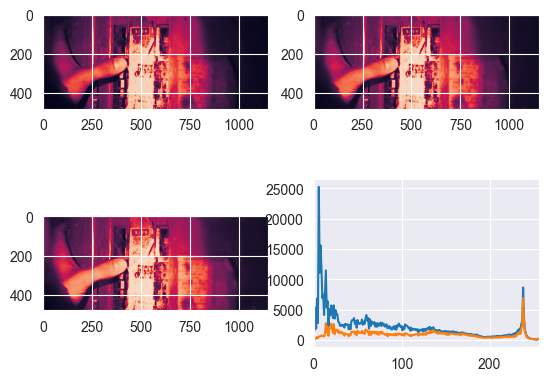

In [39]:
 #Testing Data
hist_size = 256
frames = read_video(os.path.join('train_dataset', 'video', '24.mp4'))

for i in range(0, 855):
    next(frames)
frame = next(frames)
height, width, _ = frame.shape
mask = np.zeros((height, width), np.uint8)
masked_img = frame[(height // 5):(4 * height // 5), (width // 7):(6 * width // 7)]
mask[(height // 5):(4 * height // 5), (width // 7):(6 * width // 7)] = 255
sobel_img = cv2.Sobel(frame[:,:,0],cv2.CV_8U,1,0) + cv2.Sobel(frame[:,:,0],cv2.CV_8U,0,1)
frame = next(frames)
sobel_img_2 = cv2.Sobel(frame[:,:,0],cv2.CV_8U,1,0) + cv2.Sobel(frame[:,:,0],cv2.CV_8U,0,1)
sobel_img = np.where(sobel_img - sobel_img_2 > 245, 255, 0)
hist_full = hist(frame, None, hist_size)
hist_mask = hist(frame, mask, hist_size)
plt.subplot(221), plt.imshow(frame[:,:,0])
plt.subplot(222), plt.imshow(frame[:,:,1])
plt.subplot(223), plt.imshow(frame[:,:,2])
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,hist_size])
plt.show()

In [141]:
for i in range(14, 15):
    frames = read_video(os.path.join('train_dataset', 'video', f'{i}.mp4'))
    os.makedirs(f'{i}')
    for idx, frame in tqdm(enumerate(frames)):
        path = f"{i}/{idx}.png"
        cv2.imwrite(path, frame)

C:\Users\doodo\AppData\Local\Temp\ipykernel_21448\1342939434.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames)):


0it [00:00, ?it/s]

In [8]:
def my_get_train_data(train_videos):
    X_train, y_train = pd.DataFrame(), np.array([])
    for video in tqdm(train_videos):
        frames = read_video(os.path.join('train_dataset', 'video', f'{video}.mp4'))
        # baseline функция попиксельного сравнения кадров из прошлого задания
        # нам нужны не сами смены сцен, а только значения метрик
        metrics = metric_generator(frames)

        cuts = load_json_from_file(os.path.join('train_dataset', 'gt', f'{video}.json'))['cut']
        video_scenes = np.array([False for i in range(len(metrics))])
        video_scenes[cuts] = True

        # добавляем в разметку текущее видео
        X_train = X_train.append(metrics)
        y_train = np.hstack((y_train, video_scenes))

    return X_train, y_train

In [122]:
def my_get_train_data_dissolve(train_videos):
    X_train, y_train = pd.DataFrame(), np.array([])
    for video in tqdm(train_videos):
        frames = read_video(os.path.join('train_dataset', 'video', f'{video}.mp4'))
        # baseline функция попиксельного сравнения кадров из прошлого задания
        # нам нужны не сами смены сцен, а только значения метрик
        metrics = metric_generator(frames)
        dissolves = []
        cuts = load_json_from_file(os.path.join('train_dataset', 'gt', f'{video}.json'))['dissolve']
        for l in cuts:
            dissolves.extend(range(l[0], l[1] + 1))
        video_scenes = np.array([False for i in range(len(metrics))])
        video_scenes[dissolves] = True

        # добавляем в разметку текущее видео
        X_train = X_train.append(metrics)
        y_train = np.hstack((y_train, video_scenes))

    return X_train, y_train

In [11]:

def scene_change_detector_ml(frames, with_vis = False):

    def pixel_metric(frame, prev_frame):
        return np.nanmean((frame.astype(np.int32) - prev_frame) ** 2)
    def hist_metric(frame_hist,prev_frame_hist):
        return np.nanmean(abs(frame_hist - prev_frame_hist))
    def hist(frame, mask, hist_size):
        return cv2.calcHist([frame],[0], mask, [hist_size], [0, 256])

    def metric_generator(frames):
        metrics = []
        metric_values = []
        hist_metric_values = []

        ### START CODE HERE ###
        # Ваши внешние переменные

        mask = None

        prev_frame = None
        prev_frame_hist = None
        hist_size = 64
        frames_seq_len = 7

        ###  END CODE HERE  ###

        for idx, frame in tqdm(enumerate(frames), leave=False):
            # frame - это кадр
            # idx - это номер кадра
            mean = float(0)
            hist_mean = float(0)
            frame_features = {}
            if mask is None:
                height, width, _ = frame.shape
                mask = np.zeros((height, width), np.uint8)
                mask[(height // 5):(4 * height // 5), (width // 7):(6 * width // 7)] = 255

            ### START CODE HERE ###
            frame_hist = hist(frame, mask, hist_size)
            if prev_frame is not None:
                metric_value = pixel_metric(frame, prev_frame)
                hist_metric_value = hist_metric(frame_hist, prev_frame_hist)
                metric_values.append(metric_value)
                hist_metric_values.append(hist_metric_value)
                frame_features['metric_value'] = metric_value
                frame_features['hist_metric_value'] =  hist_metric_value

                if idx >= frames_seq_len - 1:
                    mean = float(np.nanmean(metric_values[-frames_seq_len: idx - ((frames_seq_len + 1) // 2) + 1] + metric_values[idx - ((frames_seq_len + 1) // 2) + 2:]))
                    hist_mean = float(np.nanmean(hist_metric_values[-frames_seq_len: idx - ((frames_seq_len + 1) // 2) + 1] + hist_metric_values[idx - ((frames_seq_len + 1) // 2) + 2:]))
                    metrics[idx - ((frames_seq_len + 1) // 2) + 1]['mean'] = mean
                    metrics[idx - ((frames_seq_len + 1) // 2) + 1]['hist_mean'] = hist_mean
                elif idx == frames_seq_len - 2:
                    for i in range(0, (frames_seq_len) // 2):
                        mean = float(np.nanmean(metric_values[0: i] + metric_values[i + 1 : (frames_seq_len)// 2 + i + 1]))
                        metrics[i]['mean'] = mean
                        hist_mean = float(np.nanmean(hist_metric_values[0: i] + hist_metric_values[i + 1 : (frames_seq_len)// 2 + i + 1]))
                        metrics[i]['hist_mean'] = hist_mean
            else:
                frame_features['metric_value'] = 0
                metric_values.append(0)
                frame_features['hist_metric_value'] = 0
                hist_metric_values.append(0)
            prev_frame = frame
            prev_frame_hist = frame_hist
            metrics.append(frame_features)
            ###  END CODE HERE  ###
        for i in range(len(metric_values) - (frames_seq_len) // 2, len(metric_values)):
            mean = float(np.nanmean(metric_values[i - (frames_seq_len) // 2 : i] + metric_values[i + 1 : len(metric_values)]))
            metrics[i]['mean'] = mean
            hist_mean = float(np.nanmean(hist_metric_values[i - (frames_seq_len) // 2 : i] + hist_metric_values[i + 1 : len(metric_values)]))
            metrics[i]['hist_mean'] = hist_mean
        return metrics

    X_test = pd.DataFrame(metric_generator(frames))
    # загружаем модель и делаем предсказания
    model = pickle.load(open("model.pkl", 'rb'))
    predict_cuts = model.predict(X_test)
    return np.where(predict_cuts > 0)[0]

In [120]:
video = '03'
dissolves = []
cuts = load_json_from_file(os.path.join('train_dataset', 'gt', f'{video}.json'))['dissolve']
for l in cuts:
    dissolves.extend(range(l[0], l[1] + 1))

In [121]:
dissolves

[422,
 423,
 424,
 425,
 426,
 427,
 428,
 538,
 539,
 540,
 541,
 542,
 543,
 781,
 782,
 783,
 784,
 785,
 786,
 787,
 915,
 916,
 917,
 918,
 919,
 920,
 921,
 1648,
 1649,
 1650,
 1651,
 1652,
 1653,
 1654,
 1768,
 1769,
 1770,
 1771,
 1772,
 1773,
 1774,
 2071,
 2072,
 2073,
 2074,
 2075,
 2076,
 2077,
 2226,
 2227,
 2228,
 2229,
 2230,
 2231,
 2232]

In [22]:
frames = read_video(os.path.join('train_dataset', 'video', '14.mp4'))
X_train_s = metric_generator(frames)
X_train_s = pd.DataFrame(X_train_s)

C:\Users\doodo\AppData\Local\Temp\ipykernel_1852\2724818439.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [9]:
train_videos = ['04', '03', '05', '10', '07', '21', '22', '24']
# '24','23','26','25'
#
#, '14', '17', '08'
X_train, y_train = my_get_train_data(train_videos)

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\706906862.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for video in tqdm(train_videos):


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3588072560.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\706906862.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(metrics)
C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3588072560.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\706906862.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(metrics)
C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3588072560.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\706906862.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(metrics)
C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3588072560.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\706906862.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(metrics)
C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3588072560.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\706906862.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(metrics)
C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3588072560.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\706906862.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(metrics)
C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3588072560.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\706906862.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(metrics)
C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3588072560.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\706906862.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(metrics)


In [ ]:
train_features = X_train
train_features["is_cut"] = y_train

<AxesSubplot:xlabel='is_cut', ylabel='hist_mean'>

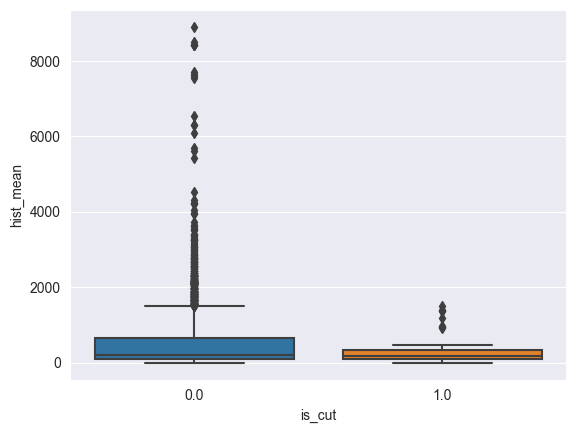

In [91]:
sns.boxplot(
    data = train_features,
    x = 'is_cut',
    y = 'hist_mean',
)

In [12]:
train_features_json = train_features.to_json()

In [18]:
with open('train_features.json', 'w') as f:
    f.write(train_features_json)

In [65]:
train_features[train_features.is_cut == True]

,metric_value,hist_metric_value,mean,hist_mean,is_cut
80,3476.272690,9.269046e+08,594.864337,133074864.0,1.0
137,3522.453674,1.050390e+08,781.753825,15937765.0,1.0
236,3679.313353,7.827634e+08,773.613122,142556368.0,1.0
323,3016.214865,2.922631e+08,750.098955,42663136.0,1.0
472,2622.665550,3.009939e+08,765.693628,45974548.0,1.0
538,3126.071298,1.169361e+09,1162.465180,171844752.0,1.0
677,4504.607294,8.255324e+08,1194.087990,124572888.0,1.0
745,4437.530721,2.185859e+09,660.748464,312552128.0,1.0
885,3279.402293,1.128361e+09,477.464376,161279664.0,1.0
1080,2262.528938,1.438220e+08,448.881085,32646876.0,1.0


In [66]:
X_train = X_train.drop('is_cut', axis=1)

In [71]:
X_train

,metric_value,hist_metric_value,mean,hist_mean
0,0.000000,0.000,0.006213,9.708333
1,0.001773,7.625,0.016620,631.218750
2,0.001989,4.500,0.029862,1926.975000
3,0.014878,17.000,0.029092,1742.416667
4,0.049614,2503.375,0.059301,3746.562500
...,...,...,...,...
3387,1.613114,141297.250,1.819614,72146.164062
3388,1.623444,21745.125,1.577113,70680.375000
3389,1.531215,9029.875,1.514822,58404.050781
3390,1.688390,78842.125,1.467588,48744.656250


In [40]:
np.where(y_train > 0)[0]

array([  232,   282,   715,  1232,  1279,  1418,  1571,  1622,  1824,
        1953,  2004,  2042,  2281,  2412,  2440,  2471,  2517,  2563,
        2618,  2722,  2773,  2809,  3000,  3330,  3387,  3486,  3573,
        3722,  3788,  3927,  3995,  4135,  4330,  4437,  4531,  4649,
        4708,  4793,  4900,  4959,  5007,  5058,  5113,  5210,  5477,
        5843,  5908,  6007,  6062,  6134,  6232,  6326,  6431,  6647,
        7670,  7853,  8162,  8355,  8430,  8504,  8532,  8813,  9134,
        9193,  9350,  9392,  9670, 10108, 10354, 10576, 11099, 12448,
       12474, 12517, 12577, 12619, 12659, 12703, 12731, 12794, 12833,
       12882, 12914, 12955, 12986, 13043, 13077, 13122, 13141, 13161,
       13184, 13253, 13279, 13328, 13360, 13396, 13440, 13475, 13493,
       13513, 13534, 13545, 13554, 13567, 13609, 13678, 13694, 13751,
       13784, 13804, 13819, 13837, 13851, 13880, 13908, 13926, 13948,
       13968, 13990, 14007, 14032, 14046, 14067, 14089, 14100, 14119,
       14138, 14166,

In [14]:
type(X_train['metric_value'])

pandas.core.series.Series

In [10]:
params = {"kernel": "rbf", "C": 1, 'class_weight' :'balanced'}
model = SVC(**params)
model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced')

In [16]:
clf = DecisionTreeClassifier(class_weight='balanced')

In [33]:
from sklearn.linear_model import LogisticRegression

In [137]:
clf = LogisticRegression(class_weight='balanced')

In [138]:
clf.fit(X_train, y_train)

C:\Users\doodo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [58]:
train_Y = clf.predict(X_train)

In [19]:
from sklearn.metrics import accuracy_score

print('Метрика на тренировочной выборке', accuracy_score(y_train, train_Y))

NameError: name 'train_Y' is not defined

In [11]:
pickle.dump(model, open("model.pkl", "wb"))

In [139]:
pickle.dump(clf, open("model.pkl", "wb"))

In [128]:
model = pickle.load(open("model.pkl", 'rb'))
predict_cuts = model.predict(X_train)

In [18]:
video_info = load_json_from_file(os.path.join('train_dataset', 'info.json'))[7]

frames = read_video(os.path.join('train_dataset', video_info['source']))
video_len = video_info['len']
true_scene_changes = load_json_from_file(os.path.join('train_dataset', video_info['scene_change']))

# Составляем список сцен, которые не будут тестироваться
not_use_frames = set()
for type_scene_change in ['trash', 'fade', 'dissolve']:
    for bad_scene_range in true_scene_changes.get(type_scene_change, []):
        not_use_frames.update(list(range(bad_scene_range[0], bad_scene_range[1] + 1)))

In [62]:
X_test = pd.DataFrame(metric_generator(frames))

C:\Users\doodo\AppData\Local\Temp\ipykernel_12164\793930596.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames)):


0it [00:00, ?it/s]

In [63]:
X_test

,metric_value,hist_metric_value
0,0.000000,0.000
1,171.019313,1026380.125
2,184.306526,1249327.750
3,194.518409,1442278.500
4,200.839658,1192360.250
...,...,...
2899,68.034040,99775.500
2900,69.164378,135233.125
2901,72.228958,109422.875
2902,81.523982,84343.875


In [23]:
predict_cuts = model.predict(X_test)

NameError: name 'X_test' is not defined

In [22]:
type(predict_cuts)

NameError: name 'predict_cuts' is not defined

In [12]:
def baseline_scene_change_detection_ml(frames):
    # подготавливаем данные для видео


    X_test = pd.DataFrame(metric_generator(frames))

    # загружаем модель и делаем предсказания
    model = pickle.load(open("model.pkl", 'rb'))
    predict_cuts = model.predict(X_test)
    return np.where(predict_cuts > 0)[0]

In [13]:
def run_scene_change_detector_ml_one_video(scene_change_detector, dataset_path, video_num):
    video_info = load_json_from_file(os.path.join(dataset_path, 'info.json'))[video_num]

    # Загружаем видео, его длину и смены сцен
    frames = read_video(os.path.join(dataset_path, video_info['source']))
    video_len = video_info['len']
    true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))

    # Составляем список сцен, которые не будут тестироваться
    not_use_frames = set()
    for type_scene_change in ['trash', 'fade', 'dissolve']:
        for bad_scene_range in true_scene_changes.get(type_scene_change, []):
            not_use_frames.update(list(range(bad_scene_range[0], bad_scene_range[1] + 1)))

    predicted_scene_changes = scene_change_detector(frames)

    return  f1_score(
        true_scene_changes['cut'],
        predicted_scene_changes,
        video_len,
        not_use_frames
    )


In [23]:
video_num = 2
run_scene_change_detector_ml_one_video(baseline_scene_change_detection_ml, 'train_dataset', video_num)

C:\Users\doodo\AppData\Local\Temp\ipykernel_3008\3174867180.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- hist_mean
- mean


In [14]:
def run_scene_change_detector_all_video(scene_change_detector, dataset_path):
    video_dataset = load_json_from_file(os.path.join(dataset_path, 'info.json'))
    param_log = {
        '_mean_f1_score': []
    }
    for video_info in tqdm(video_dataset, leave=False):
        # Загружаем видео, его длину и смены сцен
        frames = read_video(os.path.join(dataset_path, video_info['source']))
        video_len = video_info['len']
        true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))

        # Составляем список сцен, которые не будут тестироваться
        not_use_frames = set()
        for type_scene_change in ['trash', 'fade', 'dissolve']:
            for bad_scene_range in true_scene_changes.get(type_scene_change, []):
                not_use_frames.update(list(range(bad_scene_range[0], bad_scene_range[1] + 1)))

        predicted_scene_changes = scene_change_detector(frames)

        param_log['f1_score_{}'.format(video_info['source'])] = f1_score(
            true_scene_changes['cut'],
            predicted_scene_changes,
            video_len,
            not_use_frames
        )
        video_tp, video_fp, video_tn, video_fn = calculate_matrix(
            true_scene_changes['cut'],
            predicted_scene_changes,
            video_len,
            not_use_frames
        )

        param_log['tp_{}'.format(video_info['source'])] = video_tp
        param_log['fp_{}'.format(video_info['source'])] = video_fp
        param_log['tn_{}'.format(video_info['source'])] = video_tn
        param_log['fn_{}'.format(video_info['source'])] = video_fn
        param_log['_mean_f1_score'].append(param_log['f1_score_{}'.format(video_info['source'])])
    param_log['_mean_f1_score'] = np.mean(param_log['_mean_f1_score'])
    return param_log

In [15]:
video_dataset_path = 'test_dataset'
#Протестируем разработанный вами метод
run_scene_change_detector_all_video(baseline_scene_change_detection_ml, video_dataset_path)

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3144252180.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for video_info in tqdm(video_dataset, leave=False):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3588072560.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_20484\3588072560.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

{'_mean_f1_score': 0.8611111111111112,
 'f1_score_video/14.mp4': 0.7222222222222222,
 'tp_video/14.mp4': 39,
 'fp_video/14.mp4': 29,
 'tn_video/14.mp4': 1872,
 'fn_video/14.mp4': 1,
 'f1_score_video/08.mp4': 1.0,
 'tp_video/08.mp4': 23,
 'fp_video/08.mp4': 0,
 'tn_video/08.mp4': 2587,
 'fn_video/08.mp4': 0}

In [111]:
def calculate_matrix_dissolve(true_scd, predicted_scd, scene_len):
    tp, fp, tn, fn = 0, 0, 0, 0
    scene_len = scene_len
    checked_dissolve_segments = set()
    total_scene_dissolve_len = np.sum([dissolve_segment[1] - dissolve_segment[0] + 1 for dissolve_segment in true_scd])
    for scd in predicted_scd:
        for dissolve_segment in true_scd:
            if scd in range(dissolve_segment[0], dissolve_segment[1] + 1):
                tp += 1
                checked_dissolve_segments.add(tuple(dissolve_segment))
                break
        else:
            fp += 1
    fn = len(true_scd) - len(checked_dissolve_segments)
    tn = scene_len - total_scene_dissolve_len + len(true_scd) - tp - fp - fn
    return tp, fp, tn, fn


def f1_score_dissolve(true_scd, predicted_scd, scene_len):
    tp, fp, tn, fn = calculate_matrix_dissolve(true_scd, predicted_scd, scene_len)
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)

In [112]:
def run_scene_change_detector_all_video_dissolve(scene_change_detector, dataset_path):
    video_dataset = load_json_from_file(os.path.join(dataset_path, 'info.json'))
    param_log = {
        '_mean_f1_score': []
    }
    for video_info in tqdm(video_dataset, leave=False):
        frames = read_video(os.path.join(dataset_path, video_info['source']))
        video_len = video_info['len']
        true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))

        predicted_scene_changes = scene_change_detector(frames)
        param_log['f1_score_{}'.format(video_info['source'])] = f1_score_dissolve(
            true_scene_changes.get('dissolve', []),
            predicted_scene_changes,
            video_len
        )
        video_tp, video_fp, video_tn, video_fn = calculate_matrix_dissolve(
            true_scene_changes.get('dissolve', []),
            predicted_scene_changes,
            video_len
        )
        param_log['tp_{}'.format(video_info['source'])] = video_tp
        param_log['fp_{}'.format(video_info['source'])] = video_fp
        param_log['tn_{}'.format(video_info['source'])] = video_tn
        param_log['fn_{}'.format(video_info['source'])] = video_fn
        param_log['_mean_f1_score'].append(param_log['f1_score_{}'.format(video_info['source'])])
    param_log['_mean_f1_score'] = np.mean(param_log['_mean_f1_score'])
    return param_log

In [126]:
video_dataset_path = 'test_dataset'
run_scene_change_detector_all_video_dissolve(baseline_scene_change_detection_ml, video_dataset_path)

C:\Users\doodo\AppData\Local\Temp\ipykernel_1852\756319126.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for video_info in tqdm(video_dataset, leave=False):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_1852\3017070526.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

C:\Users\doodo\AppData\Local\Temp\ipykernel_1852\3017070526.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, frame in tqdm(enumerate(frames), leave=False):


0it [00:00, ?it/s]

{'_mean_f1_score': 0.11695906432748539,
 'f1_score_video/14.mp4': 0.23391812865497078,
 'tp_video/14.mp4': 40,
 'fp_video/14.mp4': 262,
 'tn_video/14.mp4': 1987,
 'fn_video/14.mp4': 0,
 'f1_score_video/08.mp4': 0,
 'tp_video/08.mp4': 0,
 'fp_video/08.mp4': 123,
 'tn_video/08.mp4': 3213,
 'fn_video/08.mp4': 1}